# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Контролировать добросовестность кассиров при продаже алкоголя.

Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Разобьем наше решение на несколько частей для детальной проработки вопроса, а именно:

- Исследуем наши данные и опишем с чем нам придется работать в дальнейшем

- Обучим нашу модель на представленных данных

- Проанализируем результаты, полученные в процессе обучения модели

Разделим наш проект на несколько частей:

[Исследовательский анализ данных](#step_1)

[Обучение модели](#step_2)

[Анализ обученной модели](#step_3)

[Чек-лист готовности проекта](#step_4)

<a id=step_1></a>
## Исследовательский анализ данных

Загрузим необходимые библиотеки

In [3]:
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Загрузим наши данные

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Что из себя представляем наш файл

In [7]:
labels.shape

(7591, 2)

In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [9]:
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Итак... у нас есть файл, состощий из столбцов с наименованием файлов (фичи) и возраста (целевые признаки).

Данные состоят из 7591 строки (фото/ссылок на файлы), пропущенных значений нет.

Данных не особо много. Размер изображений мы выбрали 224х224.

Можно работать.

Распакуем наши данные и сформируем из них фичи и целевые признаки

In [10]:
features, target = next(train_gen_flow)

Посмотрим на размер выборки

In [11]:
features.shape

(32, 224, 224, 3)

Посмотрим как распределяются возрасты в нашей выборке

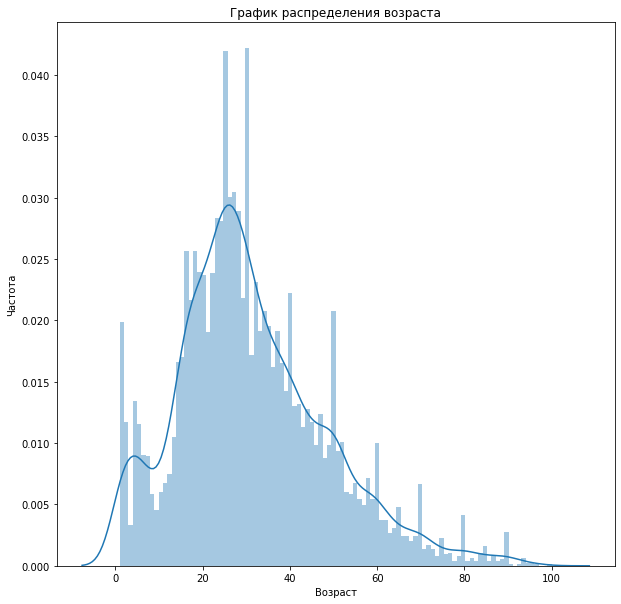

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.distplot(labels['real_age'], ax=ax, bins=100)
ax.set_title('График распределения возраста')
ax.set_xlabel('Возраст')
ax.set_ylabel('Частота')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='real_age'>

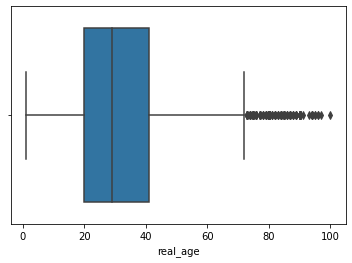

In [6]:
sns.boxplot(labels["real_age"])

Из данной визуализации можно сделать вывод, что больше всего в выборке встречаются люди в возрасте от 20 до 40 лет. Медианное значение на отметке чуть менее 30 лет. На отметках юбилейных лет заментно явное смещения числа фотографий от межюбелейных дат. Скорее всего при разметке данных не смогли определить точный возраст и округлили до юбилейного.

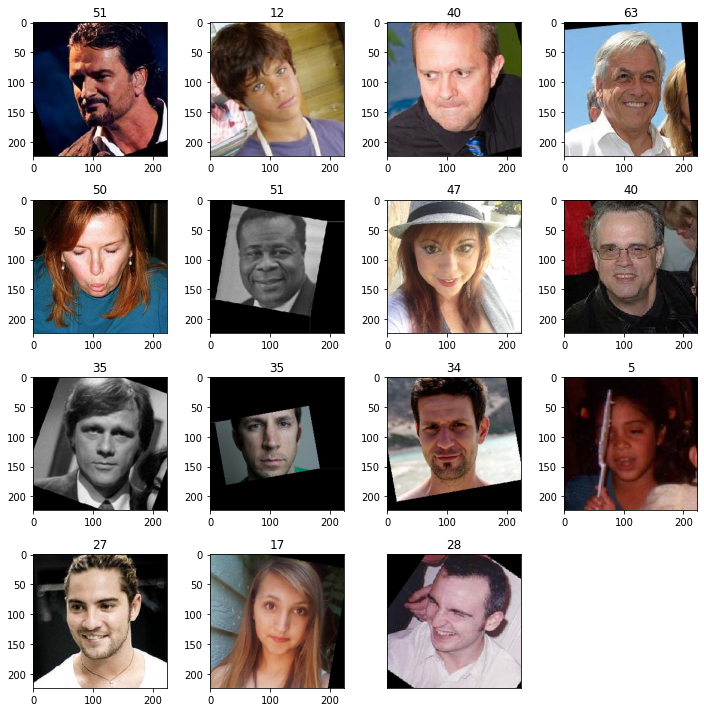

In [18]:
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.title(target[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
plt.xticks([])
plt.yticks([])
plt.tight_layout()

В нашей выборке присутствуют 7591 изображение людей.

По выведенным на экран фото можно сделать вывод, что в наших данных присутствуют фотографии "старых" лет (черно-белые), некоторые изображения с неполностью открытым лицом, изображения имеют разный размер.

Данные моменты могут неоднозначно сказаться на определении возраста обучаемой моделью.

Однако все изображения отцентрированы по горизонтали и вертикали, поэтому поворачивать и смещать не будем.

<a id=step_2></a>
## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+"/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 65s - loss: 230.1223 - mae: 10.8397 - val_loss: 803.1245 - val_mae: 23.4338
Epoch 2/5
178/178 - 37s - loss: 77.8004 - mae: 6.5956 - val_loss: 834.3259 - val_mae: 23.9806
Epoch 3/5
178/178 - 37s - loss: 49.3652 - mae: 5.3161 - val_loss: 282.4907 - val_mae: 12.2256
Epoch 4/5
178/178 - 37s - loss: 34.9069 - mae: 4.5255 - val_loss: 131.6871 - val_mae: 8.8874
Epoch 5/5
178/178 - 37s - loss: 30.2440 - mae: 4.1249 - val_loss: 90.3749 - val_mae: 7.1894
60/60 - 9s - loss: 90.3749 - mae: 7.1894
Test MAE: 7.1894

```

<a id=step_3></a>
## Анализ обученной модели

Выберем модель RESNET50 (RESIDUAL NETWORK).

Эта модель Machine Learning также обучена на более чем 1 миллионе изображений из базы данных ImageNet. ResNet50 может классифицировать до 1000 объектов. Принимает на вход цветные изображения размером 224×224 пикселей. Данная сеть была разработана с целью избавиться от затухающих и взрывных градиентов.

При обучении модели мы использовали следующие параметры и улучшения:

- Sequential из Keras - просто линейный набор слоев нейронной сети

- добавляем слой ResNet50

- добавляем слой GlobalAveragePooling2D - глобальной средней подвыборки(субдискретизации)

- добавляем слой Dense - обычный плотно связанный слой с активацией нейронов ReLU

- оптимизируем параметры при помощи оптимизатора Adam

При обучении модели мы добились значение MAE на уровне 4.1246 на обучающей выборке и 7.1894 на тестовой.

Такой прогноз необходимо довести до внимания заказчика для планирования последующих действий, т.к. ошибка в 7 лет в некоторых случаях может негативно сказаться на бизнесе.

<a id=step_4></a>
## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы